# The survival of the Gaussian distribution

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import corner
import sys 
import h5py
from astropy.io import fits
sys.path.append("../code/")
import perform_all_fits as paf
from path_handler import PathHandler
ph = PathHandler()

## Build the model

$$ f(x) = (1-\alpha) \mathcal{N}(x|\mu,\sigma) + \alpha \Gamma(x|\vec{\theta})$$

$\mathcal{N}$ is my gaussian distribution, and $\Gamma$ is a right skew distribution, i.e. the gamma dist. $\alpha$ is a weighting parameter that dictates how much each component weights towards the final signal 

## Load in the fitting results
- which which two surveys to compare

In [2]:
# output name 
foldername ="EQ6_divided_by_EQ2"
filename = "band_depth_ratio_survival_gauss_gamma_fits.hdf5"
outfname=ph.global_distributions(foldername,filename)

In [56]:
EQ2, EQ6 = paf.open_EQ2_EQ6_band_depths()
numerator = EQ6
denominator = EQ2

In [57]:
myoutdata = h5py.File(outfname,"r")

In [81]:
model_parameter=myoutdata['model_parameter'][:]
model_parameter_names=myoutdata['model_parameter_names'][:]
surface_content_parameter_names=myoutdata['surface_content_parameter_names'][:]
surface_content_parameters=myoutdata['surface_content_parameters'][:]
model_parameter_names = np.array(model_parameter_names,dtype='str')
surface_content_parameter_names = np.array(surface_content_parameter_names,dtype='str')

In [82]:
## Discard the failed fits
drop_critera=surface_content_parameters[:,0]==1
my_results = surface_content_parameters[~drop_critera]

In [90]:
import matplotlib
available_fonts = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])
for fontname in available_fonts:
    print(fontname)

Bitstream Vera Sans
Bitstream Vera Sans
Bitstream Vera Sans
Bitstream Vera Sans
Bitstream Vera Sans Mono
Bitstream Vera Sans Mono
Bitstream Vera Sans Mono
Bitstream Vera Sans Mono
Bitstream Vera Serif
Bitstream Vera Serif
C059
C059
C059
C059
D050000L
DejaVu Math TeX Gyre
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans
DejaVu Sans Display
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Sans Mono
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif
DejaVu Serif Display
Droid Sans Fallback
FreeMono
FreeMono
FreeMono
FreeMono
FreeSans
FreeSans
FreeSans
FreeSans
FreeSerif
FreeSerif
FreeSerif
FreeSerif
Latin Modern Math
Latin

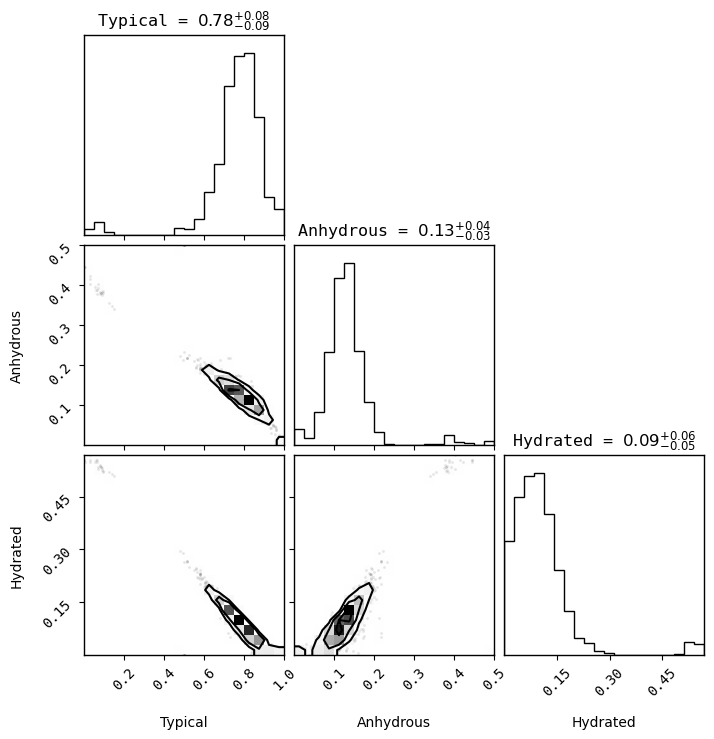

In [92]:
fontname = "DejaVu Sans Mono"
fig=corner.corner(my_results,labels=surface_content_parameter_names,show_titles=True);
for ax in fig.get_axes():
    # Set the font size for the axis labels
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(10)
    # Set the font size for the tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='major', labelsize=10)
    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname)  # Change to your desired font
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname)  # Change to your desired font
    
    # Set the font size and type for the titles (if any)
    if ax.title:
        ax.title.set_size(12)
        ax.title.set_fontname(fontname)  # Change to your desired font



### Load the band-depth ratio's

In [117]:
mymedian=np.median(surface_content_parameters,axis=0)
distance = np.linalg.norm(surface_content_parameters-mymedian,axis=1)
jj=np.argmin(distance)
print(mymedian)

[0.79433888 0.12256977 0.08212755]


In [103]:
# pick an exampled globla distribution
ratio = numerator[:,jj]/denominator[:,jj]
emptyfacets = ~np.isfinite(ratio)
myratio = ratio[~emptyfacets]

prepare the histogram

In [104]:
nbins = int(np.ceil(np.sqrt(myratio.shape[0])))
counts,bins = np.histogram(myratio,bins=nbins,density=True)
centers = (bins[:-1]+bins[1:])/2

show the model fit

In [105]:
normal,gamma = paf.my_model_gamma(centers,*model_parameter[jj,:])
total = normal+gamma

In [106]:
hydrousconditions = centers >= 1
anhydrousconditions = centers <= 1

set the plot properties

In [107]:
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'axes.linewidth': 1})

In [108]:
histprop={'histtype':'step','lw':2,'color':'k',"alpha":0.2,'label':'Data'}
totalprop={'lw':2,'color':'k',"ls":'-','label':r'$\mathcal{N}+\Gamma$'}
normalprop={'lw':1,'color':'k',"ls":'-.','label':r'$\mathcal{N}$'}
gammaprop={'lw':1,'color':'k',"ls":':','label':r'$\Gamma$'}

In [109]:
xlabel=r"EQ6/EQ2 band depth ratio"
AXIS = {"yticks":[],"ylabel":r"$\mathcal{P}$","xlabel":xlabel}

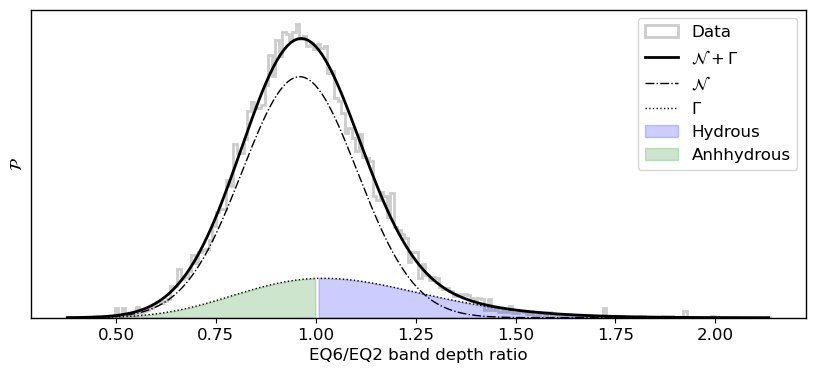

In [110]:
fig,axis=plt.subplots(1,1,figsize=(10,4));
axis.hist(myratio,bins=nbins,density=True,**histprop);
axis.plot(centers,total,**totalprop);
axis.plot(centers,normal,**normalprop);
axis.plot(centers,gamma,**gammaprop);
axis.fill_between(centers,gamma,where=hydrousconditions,alpha=0.2,color='b',label='Hydrous')
axis.fill_between(centers,gamma,where=anhydrousconditions,alpha=0.2,color='g',label='Anhhydrous')
axis.set(**AXIS)
axis.legend()

## Do a global map

grab the path to the ancillary file


In [111]:
ancfile=fits.open(ph.ancillary_file())
LAT = ancfile[1].data['LATITUDE']
LONG = ancfile[1].data['LONGITUDE']
LAT = LAT[~emptyfacets]
LONG = LONG[~emptyfacets]

In [112]:
from matplotlib import cm

In [113]:
cmap = cm.get_cmap('rainbow')
norm = plt.Normalize(vmin=0.70, vmax=1.30)

/tmp/ipykernel_921049/4026998823.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')


In [114]:
MAP = {"xlim":[0,360],"ylim":[-90,90],"xlabel":"Longitude","ylabel":"Latitude"}

In [115]:
histprop={'lw':2,"alpha":0.8}
xlabel=r"[EQ6/EQ2]"
AXIS = {"yticks":[],"ylabel":r"$\mathcal{P}$","xlabel":xlabel,"xlim":[0.5,1.75],"ylim":[0,4]}

(0.0, 4.0)

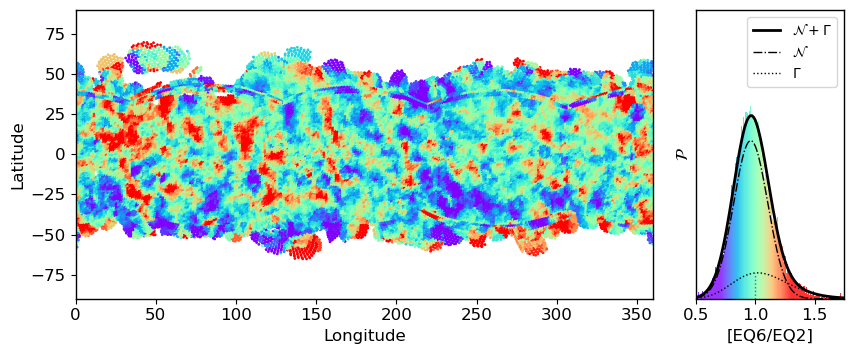

In [116]:
fig,axis=plt.subplots(1,2,figsize=(10,3.75),gridspec_kw={'width_ratios': [4, 1],"wspace":0.1},);
sc = axis[0].scatter(LONG,LAT,c=myratio,s=1,cmap=cmap,norm=norm)
axis[0].set_aspect('equal')
axis[0].set(**MAP)

n, bins, patches = axis[1].hist(myratio,bins=nbins,density=True,**histprop);
centers = (bins[:-1]+bins[1:])/2
for patch, value in zip(patches, centers):
    color = cmap(norm(value))
    patch.set_facecolor(color)

axis[1].plot(centers,total,**totalprop);
axis[1].plot(centers,normal,**normalprop);
axis[1].plot(centers,gamma,**gammaprop);
center_index = np.argmin(np.abs(centers - 1))
axis[1].vlines(1,0,gamma[center_index],linestyles='dotted',lw=1)
# axis[1].fill_between(centers,gamma,where=hydrousconditions,alpha=0.2,color='b',)
# axis[1].fill_between(centers,gamma,where=anhydrousconditions,alpha=0.2,color='g',)
axis[1].set(**AXIS)
# Put the legend on the outside and on the right of the plot
# axis[1].legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5))
axis[1].legend(fontsize=10, )
# Set the same aspect ratio for the second axis
axis[1].set_aspect(aspect='auto')
axis[1].get_ylim()